[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hustav/UNSW-COMP9414/blob/main/Week07/COMP9414-Week07-Neural-Networks-Solution.ipynb)

# Training and Assessing Neural Networks with Keras

**COMP9414 W07 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Notebook designed by Gustavo Batista
- Last Update 2nd October 2024

In this week's tutorial, we will train and assess a multi-layer perceptron, a type of "deep" neural network architecture. We will start with the well-known benchmark dataset, MNIST, with images of single handwritten digits (0-9).

We will use Keras as our main framework for implementing deep learning models. Keras is now part of the TensorFlow framework and provides a simple library for learning these models.

## Technical prerequisites

You will need the following packages installed to run this notebook:

1. Numpy
2. Matplotlib
3. Scikit-learn
4. Tensorflow

The first three libraries are often found in most installations. If they are not installed on your system, you can install them using the `pip` or `conda` commands.

TensorFlow usually requires an older Python version. If you have installation conflicts, we suggest creating an environment for TensorFlow with a compatible Python version. Alternatively, you can run this notebook on Google Colab (see link in the first cell), which has the Tensorflow library installed. You will need to install keras-tuner, though.

In [12]:
# NumPy and matplotlib libraries for numerical computation and plotting
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow/keras libraries for deep-learning models
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Keras Tuner libraries for hyperparameter tuning
# Uncomment the next line if you need to install the Keras Tuner library
# !pip install keras-tuner
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

# Scikit-learn libraries for model assessment
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

The following line will tell you how many CPUs and GPUs your system has. If you have a GPU, you can expect a speed-up in model training time.

In [13]:
print("Number CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Number GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Number CPUs Available:  1
Number GPUs Available:  0


## The MNIST dataset

We will train a simple, fully connected neural network using Keras to classify handwritten digits from the MNIST dataset.

The MNIST dataset contains 70,000 grayscale images of handwritten digits (0-9), each of size 28x28 pixels. This dataset is very popular for benchmarking Machine Learning models. It is even available as part of the TensorFlow installation.

We can use the following command to load the dataset.

In [14]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

MNIST comes with a standard splitting of training and test sets. The training set should be used for model fitting and hyperparameter search, and the test set should be used exclusively for model evaluation. Using the test set for any other task is a methodological mistake.

We have the following data splits:

1. `X_train`: the training data we will use to fit our model parameters.
2. `y_train`: the associated labels for each training case.
3. `X_test`: the test data we will use to assess the model performance.
4. `y_test`: the associated labels for each test instance.

The MNIST is a relatively large dataset. It has 60,000 training images and 10,000 test images, as we can see below:

In [15]:
print("MNIST size (number of images, number of image lines, number of image columns)")
print(X_train.shape)
print(X_test.shape)
print("These are the labels, each training or testing image has an associated label (0-9)")
print(y_train.shape)
print(y_test.shape)

MNIST size (number of images, number of image lines, number of image columns)
(60000, 28, 28)
(10000, 28, 28)
These are the labels, each training or testing image has an associated label (0-9)
(60000,)
(10000,)


Let's visualise some digits to understand how complex this problem is. The following cell plots the first six digits in the training set.

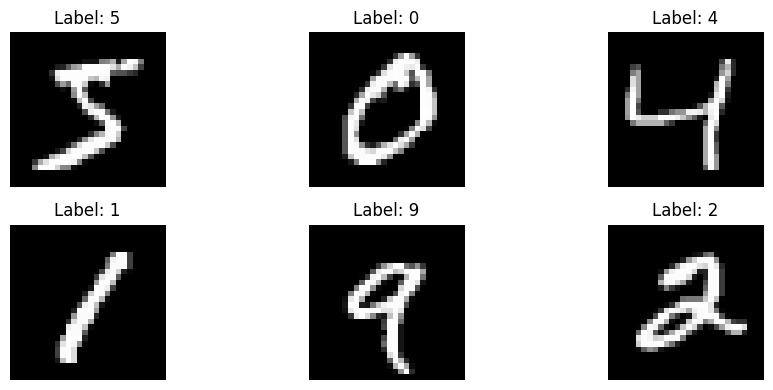

In [16]:
# Visualise the first six digits in the training set
plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

We can also visualise some images from the same digit to get an idea of the variability in each class. Feel free to change the first line to see images of the other digits.

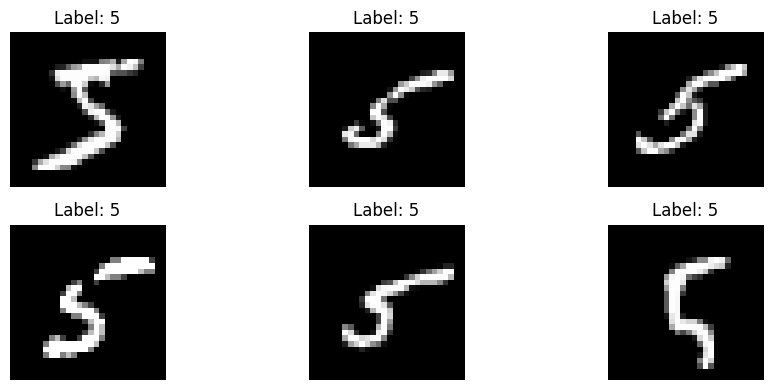

In [17]:
# Visualise the first six 'five' digits in the training set
indices = np.where(y_train == 5)[0]  # Find the indices of the images for class 5
plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[indices[i]], cmap='gray')
    plt.title(f'Label: {y_train[indices[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Before we conclude this section about the dataset, we will make two simple pre-processing:

1. Each pixel is represented by a number between 0 and 255. We will normalize the pixels to be numbers between 0 and 1, which will facilitate training.
2. We will convert the class numbers into a one-hot encoding. One-hot encodings represent the output as a vector. Each entry represents one class, and the vector will have zeros for all entries but one that represents the class.

These are examples of one-hot encodings:
1. The digit 0 is represented as [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2. The digit 5 is represented as [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
3. The digit 9 is represented as [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [18]:
# Normalise the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)

## Defining a model Neural Network model with Keras

Keras makes it very simple to create a deep-learning model. The process has three main steps:

1. Model definition: We declare the model architecture, specifying the properties of each layer, such as the number of units and activation function.
2. Model compilation: This step prepares the model for training, specifying aspects such as the optimizer, the loss function, and the metrics to be monitored during training.
3. Model fitting: This step fits the model to the dataset. In this step, we need to specify the training data, number of epochs, batch size, and validation data.

Let's define our first model with the following architecture:

1. 784 input units that correspond to the number of pixels in the image ($28 \times 28$). In this case, each normalised pixel colour will be one input to the model.
2. 64 hidden units. This design decision is difficult to justify, as the hidden units should be proportional to the data's "complexity." We will play with this hyperparameter later.
3. 10 output units. This is the number of classes, and each unit corresponds to one digit (class) in the one-hot encoding.

The following figure illustrates the neural network architecture.

![First architecture](https://github.com/hustav/UNSW-COMP9414/blob/main/Week07/img/first_model.png?raw=1)

In [19]:
model = Sequential([
    Input(shape=(28, 28)),                  # Input is a 28x28 image
    Flatten(),                              # Flatten the 28x28 input images into a 784-length vector
    Dense(64, activation='relu'),           # Hidden layer with 64 neurons and ReLU activation
    Dense(10, activation='softmax')         # Output layer with 10 neurons (one for each digit)
])

There are several observations for the previous cell:

1. The sequential model specifies that we are creating a neural network with a sequence of layers. It is a sequence in that the input layer feeds the hidden layer that feeds the output layer.
2. The input is $28 \times 28$ images, but the neural network has 784 input units. Therefore, the `Flatten` statement "flats" the matrix into a vector.
3. We follow up with two additional dense layers. The first is a hidden layer with ReLU activation, and the second is the output layer with softmax activation.

Now, we are ready to compile our model.

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Notice that in this compilation step, we specified Adam as the optimiser, cross-entropy as the loss function, and accuracy as the performance measure for later model assessment.

Finally, we can train the model for 10 epochs with a batch size of 32 images. This will take a while to complete.

In [21]:
history = model.fit(X_train, y_train_one_hot, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8407 - loss: 0.5548 - val_accuracy: 0.9452 - val_loss: 0.1920
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9500 - loss: 0.1723 - val_accuracy: 0.9581 - val_loss: 0.1459
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9658 - loss: 0.1190 - val_accuracy: 0.9638 - val_loss: 0.1269
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9731 - loss: 0.0924 - val_accuracy: 0.9664 - val_loss: 0.1092
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9788 - loss: 0.0746 - val_accuracy: 0.9678 - val_loss: 0.1102
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9810 - loss: 0.0640 - val_accuracy: 0.9723 - val_loss: 0.0942
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9839 - loss: 0.0519 - val_accuracy: 0.9721 - val_loss: 0.0962
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9878 - loss: 0.0433 -

We use 20% of the training set as a validation set. This validation set helps us to understand if the model is overfitting the training data. The following figure plots the training and validation loss and accuracy during the model training.

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Finally, we can assess the model's performance by measuring its accuracy in the test set. The test set is a partition of the data used **only** for model assessment. It should never be used for model fitting or hyperparameter search.

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_accuracy:.4f}')

Nice! We created a model with 97.31% accuracy! This is pretty accurate and may indicate that the MNIST dataset is not very difficult.

Our model makes less than 3% of mistakes in a 10,000-sample test set. Therefore, it misclassifies around 260 images. The classifier's accuracy/error gives us no information about whether we perform equally well in all classes or whether some are more difficult.

In the next cell, we will exercise to plot the confusion matrix. This will tell us which classes are the most misclassified and how they are misclassified among them.

### Exercise

A confusion matrix is a performance evaluation tool for classification models. It provides a visual summary of the model’s predictions compared to the actual values. The confusion matrix is a table. Each row represents the instances of an actual class, while each column represents the instances of a predicted class, making it easy to see which classes are most often confused with each other. A perfect model would have non-zero values only along the diagonal of the confusion matrix, indicating that all predictions are correct.

The scikit-learn library has the [``confusion_matrix``](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and [``ConfusionMatrixDisplay``](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) functions that compute and plot confusion matrices (see the links for the official documentation).

We will use the method [``model.predict``](https://keras.io/api/models/model_training_apis/) to return the classification for the test cases. The predictions come in as one-hot encoding, and we will need to convert them to numbers between 0 and 9 using the [``np.argmax``](https://numpy.org/doc/2.0/reference/generated/numpy.argmax.html) method.

The next cell will compute and plot the confusion matrix. We have done most of the work for you!

In [ ]:
# Predict on the test set
y_pred = ...                                         # TODO, call model.predict to predict the labels for X_test
y_pred_classes = ...                                 # TODO, call np.argmax to transform the predicted class probabilities (y_pred) into class 0-9 predictions

# Create the confusion matrix
cm = ...                                             # TODO, call confusion_matrix and inform the actual labels (y_test) and the predicted labels (y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Answer

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Qualitative model assessment

So far, we have assessed our model quantitatively. In the next part, we will conduct a more qualitative assessment. In a qualitative assessment, we examine the misclassified images. We aim to understand if the model is making silly mistakes or if the data has difficult images. For instance, the confusion matrix has shown us that the digit "9" is often misclassified, particularly with the digit 4. The qualitative analysis will help us to understand if these two digits are truly similar or if the model still has room for improvement.

### Exercise

Let's plot 100 incorrect predictions to better understand the classifier's performance. We have done most of the heavy lifting for you; you just need to complete one line of code.

In [ ]:
# Find misclassified images
misclassified_indices = ...                                         # TODO. Use np.where to find the indices of the images where y_pred_classes differs from y_test

# Plot a 10x10 grid of misclassified images
num_images = 100  # Number of misclassified images to display
plt.figure(figsize=(15, 15))
for i, index in enumerate(misclassified_indices[:num_images]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(X_test[index], cmap='gray')
    plt.title(f"True: {y_test[index]}\nPred: {y_pred_classes[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Answer

# Find misclassified images
misclassified_indices = np.where(y_pred_classes != y_test)[0]

# Plot a 10x10 grid of misclassified images
num_images = 100  # Number of misclassified images to display
plt.figure(figsize=(15, 15))
for i, index in enumerate(misclassified_indices[:num_images]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(X_test[index], cmap='gray')
    plt.title(f"True: {y_test[index]}\nPred: {y_pred_classes[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Hyperparameter search

Now that you understand how to create and assess your models let's see if we can improve the deep learning models' performance for the MNIST dataset.

Deep learning models have several hyperparameters that can influence their performance. Here are some ideas:

1. Model architecture: We could make the model architecture smaller or bigger and see if it can improve performance.
2. We can train the models for a longer period.
3. We can use a different optimiser, SGD, instead of ADAM.

Unfortunately, testing all possible combinations of hyperparameters is very time-consuming. However, we can assess some of these ideas against our initial model.

### Exercise

Define a new architecture with 128 hidden units instead of 64. Does this change improve accuracy?

In [ ]:
model = Sequential([
...                            # TODO
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train_one_hot, epochs=10, validation_split=0.2, batch_size=32)

test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_accuracy:.4f}')

In [ ]:
# Answer

model = Sequential([
    Input(shape=(28, 28)),                  # Input is a 28x28 image
    Flatten(),                              # Flatten the 28x28 input images into a 784-length vector
    Dense(128, activation='relu'),          # Hidden layer with 128 neurons and ReLU activation
    Dense(10, activation='softmax')         # Output layer with 10 neurons (one for each digit)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train_one_hot, epochs=10, validation_split=0.2, batch_size=32)

test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_accuracy:.4f}')

### Exercise

Define a new architecture with no hidden layer. Does this change improve accuracy?

In [ ]:
model = Sequential([
...                            # TODO
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train_one_hot, epochs=10, validation_split=0.2, batch_size=32)

test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_accuracy:.4f}')

In [ ]:
# Answer

model = Sequential([
    Input(shape=(28, 28)),                  # Input is a 28x28 image
    Flatten(),                              # Flatten the 28x28 input images into a 784-length vector
    Dense(10, activation='softmax')         # Output layer with 10 neurons (one for each digit)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train_one_hot, epochs=10, validation_split=0.2, batch_size=32)

test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_accuracy:.4f}')

### Exercise

Train the original model for 30 epochs. Does this change improve accuracy?

In [ ]:
model = Sequential([
    Input(shape=(28, 28)),                  # Input is a 28x28 image
    Flatten(),                              # Flatten the 28x28 input images into a 784-length vector
    Dense(64, activation='relu'),           # Hidden layer with 64 neurons and ReLU activation
    Dense(10, activation='softmax')         # Output layer with 10 neurons (one for each digit)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(...)                              # TODO

test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_accuracy:.4f}')

In [ ]:
# Answer

model = Sequential([
    Input(shape=(28, 28)),                  # Input is a 28x28 image
    Flatten(),                              # Flatten the 28x28 input images into a 784-length vector
    Dense(64, activation='relu'),           # Hidden layer with 64 neurons and ReLU activation
    Dense(10, activation='softmax')         # Output layer with 10 neurons (one for each digit)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train_one_hot, epochs=30, validation_split=0.2, batch_size=32)

test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_accuracy:.4f}')

Well, it seems that only increasing the model capacity improved the accuracy by a small fraction. You can try other ideas, but MNIST is a relatively easy dataset, and it becomes hard to improve when we have close to 100% accuracy.

In the next part, we will use Keras Tuner, a more systematic approach for hyperparameter optimisation.

## Parameter tuning as a search procedure with Keras Tuner

We like to think of AI as a search problem. We learned that fitting a neural network parameter is a search guided by the loss gradients, in which we look for the parameter combination that minimises the loss.

We can use a similar idea and think of hyperparameters as a search problem. In this case, we can use a validation set error or accuracy and try different combinations of hyperparameters. Unfortunately, this is a computationally expensive procedure, and neural networks have many hyperparameters to evaluate.

We can use Keras Tuner to automate the search for hyperparameters. Let's start with a simpler experiment. Motivated by the idea that the number of units in the hidden layer might be a relevant hyperparameter, we will use the Keras Tuner to try a few possibilities.

The main idea is to define a HyperModel. A HyperModel allows us to specify a set of models. In our case, these models will have different numbers of hidden units from 32 to 256 with increments of 32.

In [ ]:
class FirstHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(28, 28)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(Dense(10, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

tuner = RandomSearch(
    FirstHyperModel(),
    objective='val_accuracy',
    max_trials=5,                    # Number of different architectures to try
    executions_per_trial=3,          # Averaging over 3 different runs per architecture
    directory='log_results',         # Folder to save the results
    project_name='mnist_tuning'
)

tuner.search(X_train, y_train_one_hot, epochs=10, validation_split=0.2)
tuner.results_summary()

If you want to assess the best model in the test set, then you need to retrive it first, using the following code:

In [ ]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the independent test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_one_hot)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy:.4f}')

### Exercise

Let's try to search for more hyperparameters now. Let's try the following:
- One, two or three hidden layers
- 32 to 512 hidden units per layer in increments of 32 units
- ReLu, tanh or sigmoid activation functions
- Adam, SGD or RMSProp optimisers

This will take a while to run. We will set ``max_trials=20``, so we will not explore all combinations of hyperparameter values. If you have a more powerful computer, feel free to increase this number and explore the combinations better.

We will run this as an exercise. We have done most of the work for you but must complete a few missing parts.

In [ ]:
class SecondHyperModel(HyperModel):
    def build(self, hp):
        model = ...                                                                                         # TODO. Define the model input as in the previous first model
        model.add(...)
        model.add(...)

        # Tune the number of hidden layers (between 1 and 3)
        for i in range(hp.Int('num_layers', 1, 3)):                                                         # This is the number of hidden layers
            # Tune the number of units in each layer
            model.add(Dense(units=hp.Int('units_' + str(i), min_value=..., max_value=..., step=...),        # TODO
                            activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid'])))     # These are the activation functions

        # Output Layer                                                                                      # TODO. Define the model output as in the first model
        model.add(...)

        # Tune the learning rate for the optimizer
        optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])                                      # These are the optimisers
        if optimizer == 'adam':
            opt = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
        elif optimizer == 'sgd':
            opt = SGD(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
        else:
            opt = RMSprop(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))

        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        return model

# Instantiate the tuner
tuner = RandomSearch(
    SecondHyperModel(),
    objective='val_accuracy',
    max_trials=20,                   # Number of different models to try
    executions_per_trial=3,          # Averaging results from 3 runs
    directory='log_results',         # Folder to save the results
    project_name='mnist_tuning_large'
)

# Perform the search
tuner.search(X_train, y_train_one_hot, epochs=10, validation_split=0.2)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of layers: {best_hps.get('num_layers')}")
print(f"Best number of units in first layer: {best_hps.get('units_0')}")
print(f"Best optimizer: {best_hps.get('optimizer')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the independent test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_one_hot)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy:.4f}')

In [ ]:
# Answer

class SecondHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(28, 28)))
        model.add(Flatten())

        # Tune the number of hidden layers (between 1 and 3)
        for i in range(hp.Int('num_layers', 1, 3)):
            # Tune the number of units in each layer
            model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                            activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid'])))

        # Output Layer
        model.add(Dense(10, activation='softmax'))

        # Tune the learning rate for the optimizer
        optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
        if optimizer == 'adam':
            opt = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
        elif optimizer == 'sgd':
            opt = SGD(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
        else:
            opt = RMSprop(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))

        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        return model

# Instantiate the tuner
tuner = RandomSearch(
    SecondHyperModel(),
    objective='val_accuracy',
    max_trials=20,                   # Number of different models to try
    executions_per_trial=3,          # Averaging results from 3 runs
    directory='log_results',         # Folder to save the results
    project_name='mnist_tuning_large'
)

# Perform the search
tuner.search(X_train, y_train_one_hot, epochs=10, validation_split=0.2)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of layers: {best_hps.get('num_layers')}")
print(f"Best number of units in first layer: {best_hps.get('units_0')}")
print(f"Best optimizer: {best_hps.get('optimizer')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the independent test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_one_hot)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy:.4f}')

# Conclusion

Today, we have learned how to implement and evaluate deep learning models using Keras. In the next tutorial, we will look at decision trees and ensembles of these models, known as random forests. These are powerful models to learn from tabular datasets.